In [156]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors

In [157]:
# Custom colormap
cvals  = [0, 0.03, 0.1, 0.3, 0.6, 0.8, 1.4]
colors = ["white","khaki","yellowgreen", "mediumseagreen", "mediumaquamarine", "darkcyan", "midnightblue"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

In [158]:
# Read GED_Data and convert geom_wkt points from wkt to geometry
GED_Data = gpd.read_file("../data/ged_data_india.csv")

df= GED_Data[["geom_wkt"]]
df['geom_wkt'] = gpd.GeoSeries.from_wkt(df['geom_wkt'])
# df['deaths'] = GED_Data["deaths_a"] + GED_Data["deaths_b"] + GED_Data["deaths_civilians"] + GED_Data["deaths_unknown"] 
df['deaths'] = GED_Data["deaths_civilians"]

df['deaths'] = df['deaths'].astype(int)

gdf = gpd.GeoDataFrame(df, geometry="geom_wkt")

/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/1297722770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geom_wkt'] = gpd.GeoSeries.from_wkt(df['geom_wkt'])
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/1297722770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deaths'] = GED_Data["deaths_civilians"]
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/1297722770.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [159]:
assembly_constituencies = gpd.read_file(r"../data/maps/assembly-constituencies/India_AC.shp")
adminstrative_boundaries = gpd.read_file(r"../data/maps/india administrative boundaries/gadm41_IND_3.shp")


In [160]:
# Count conflicts using India_AC shapefile

ac_conflicts = assembly_constituencies[["Map_ID", "geometry"]]

# Spatial join AC Polygons and GED_Data Points
sjoin = gpd.sjoin(ac_conflicts, gdf, how='left', op='intersects')
map_id = 'Map_ID'

# Group by assembly constituencies and count the number of points/conflicts
count = sjoin.groupby(map_id)["geometry"].count()

# Convert to Pandas dataframe displaying political consituencies, assembly constituencies and # of conflicts.
pd_count = pd.DataFrame(count).rename(columns={"geometry": "Conflicts"})
pd_count.join(assembly_constituencies, on="Map_ID", how = "inner")[["PC_NAME", "AC_NAME", "Conflicts"]].sort_values(by=['Conflicts'], ascending=False)

/Users/christinefang/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/1058478599.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  sjoin = gpd.sjoin(ac_conflicts, gdf, how='left', op='intersects')


,PC_NAME,AC_NAME,Conflicts
Map_ID,,,
219,SRINAGAR,BEERWAH,664
199,LADAKH,LEH,661
200,BARAMULLA,SOPORE,590
1647,BASTAR (ST),Jagdalpur,447
205,LADAKH,ZANSKAR,392
...,...,...,...
1591,JANJGIR-CHAMPA (SC,Janjgir-Champa,1
1592,BILASPUR,Bilha,1
1593,DURG,Nawagarh (SC),1


Text(0.5, 1.0, 'Conflicts using IndiaAC.shp')

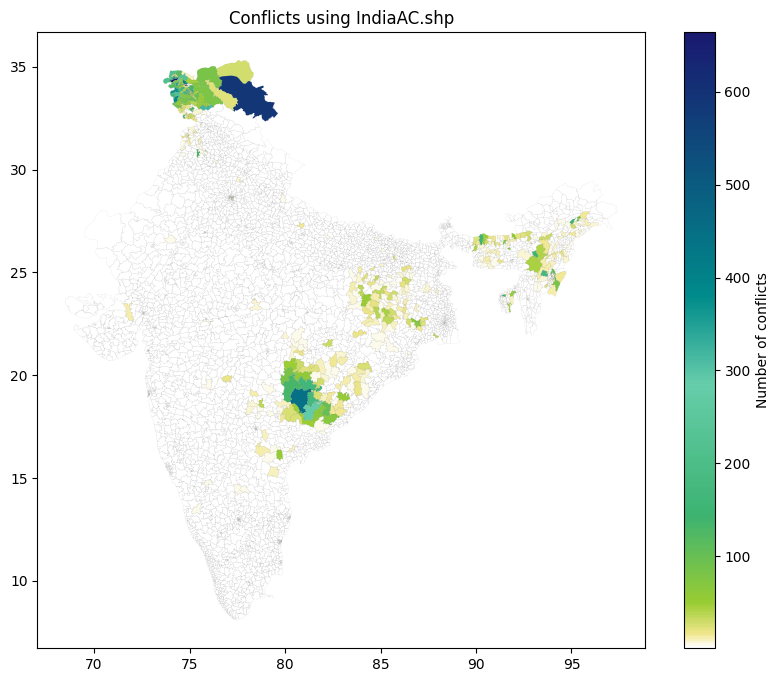

In [161]:
# Choropleth map
count.name='pointcount'
polygons = pd.merge(left=ac_conflicts, right=count, left_on=map_id, right_index=True)

fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = cmap, ax=ax, legend=True, 
              legend_kwds={'label':'Number of conflicts'})
plot = polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)

plot.set_title('Conflicts using IndiaAC.shp')


/Users/christinefang/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/1645926749.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  sjoin = gpd.sjoin(ab_conflicts, gdf, how='left', op='intersects')


Text(0.5, 1.0, 'Conflicts using gadm41_IND_3.shp')

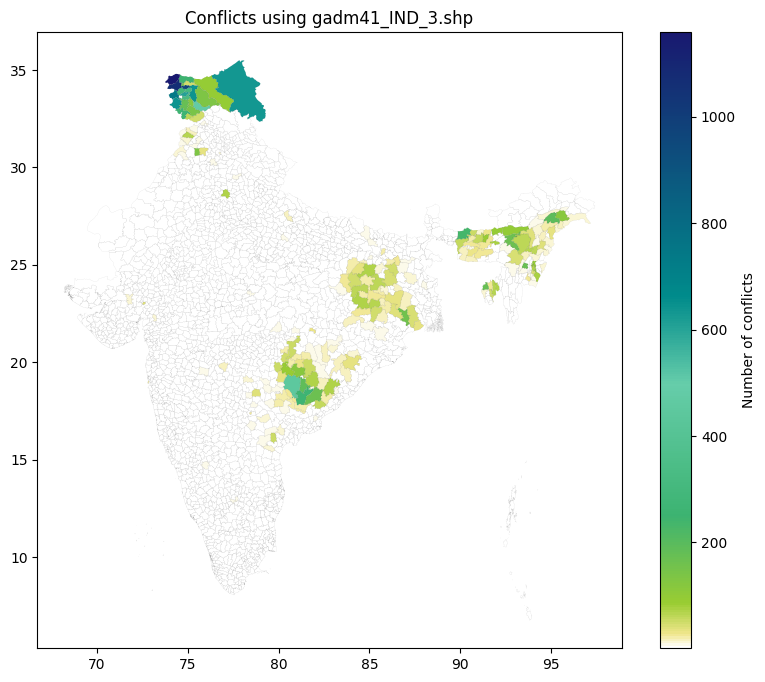

In [162]:
# Mapping conflicts using gadm41_IND_3 shapefile

ab_conflicts = adminstrative_boundaries[["GID_3", "geometry"]]

# Spatial join AC Polygons and GED_Data Points
sjoin = gpd.sjoin(ab_conflicts, gdf, how='left', op='intersects')
gid = 'GID_3'

# Group by Polygons and count the number of points/conflicts
count = sjoin.groupby(gid)[gid].count()
count.name='pointcount'
polygons = pd.merge(left=ab_conflicts, right=count, left_on=gid, right_index=True)


fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = cmap, ax=ax, legend=True, 
              legend_kwds={'label':'Number of conflicts'})
plot = polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)

plot.set_title('Conflicts using gadm41_IND_3.shp')


In [163]:
# Mapping civilian fatalities using India_AC shapefile
ac_fatalities = assembly_constituencies[["Map_ID", "geometry"]]

# Spatial join AC Polygons and GED_Data Points
sjoin = gpd.sjoin(ac_fatalities, gdf, how='left', op='intersects')
map_id = 'Map_ID'

# Group by assembly constituencies and count the number of points/conflicts
count = sjoin.groupby(map_id)["deaths"].sum()

# Convert to Pandas dataframe displaying political consituencies, assembly constituencies and # of conflicts.
pd_count = pd.DataFrame(count)
pd_count.join(assembly_constituencies, on="Map_ID", how = "inner")[["PC_NAME", "AC_NAME", "deaths"]].sort_values(by=['deaths'], ascending=False)


/Users/christinefang/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/2733940687.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  sjoin = gpd.sjoin(ac_fatalities, gdf, how='left', op='intersects')


,PC_NAME,AC_NAME,deaths
Map_ID,,,
200,BARAMULLA,SOPORE,1024.0
219,SRINAGAR,BEERWAH,418.0
2817,BEED,Beed,408.0
109,KOKRAJHAR,Bhabanipur,284.0
3311,ANANDPUR SAHIB,Chamkaur Sahib (SC),251.0
...,...,...,...
1576,KORBA,Rampur (ST),0.0
1577,BILASPUR,Lormi,0.0
1578,RAIGARH (ST),Lailunga (ST),0.0


count.name='pointcount'
polygons = pd.merge(left=ac, right=count, left_on=gid, right_index=True)


fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = cmap, ax=ax, legend=True, 
              legend_kwds={'label':'Number of conflicts'})
polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)

Text(0.5, 1.0, 'Fatalities using IndiaAC.shp')

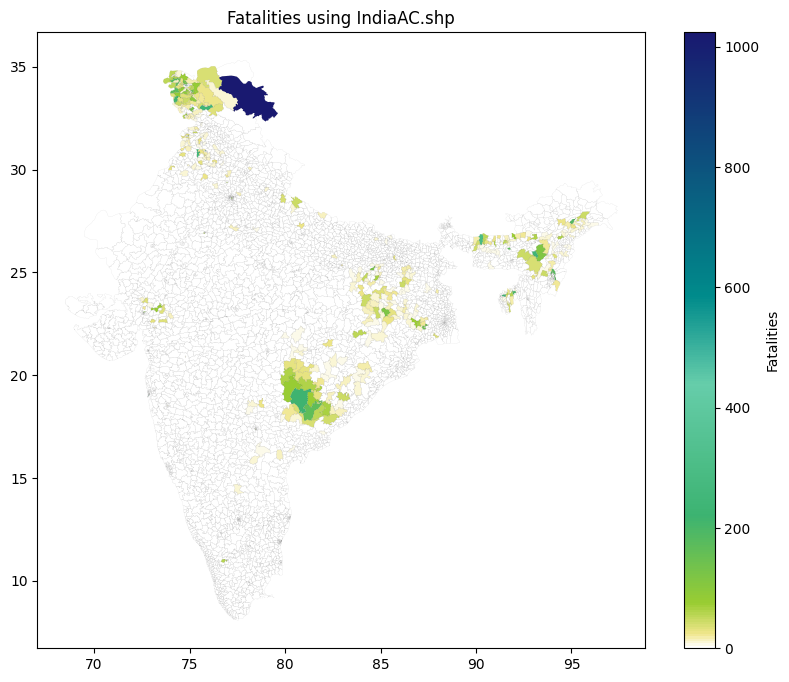

In [164]:
# Choropleth map
count.name='pointcount'
polygons = pd.merge(left=ac_fatalities, right=count, left_on=map_id, right_index=True)

fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = cmap, ax=ax, legend=True, 
              legend_kwds={'label':'Fatalities'})
plot = polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)

plot.set_title('Fatalities using IndiaAC.shp')


/Users/christinefang/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_85361/1272749667.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  sjoin = gpd.sjoin(ab_fatalities, gdf, how='left', op='intersects')


Text(0.5, 1.0, 'Fatalities using gadm41_IND_3.shp')

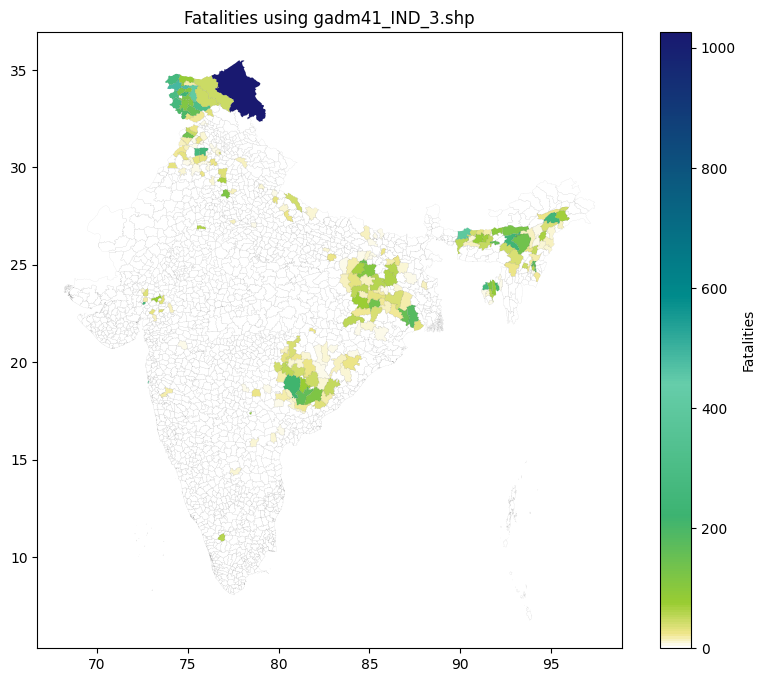

In [165]:
# Mapping civilian fatalities using gadm41_IND_3 shapefile
ab_fatalities = adminstrative_boundaries[["GID_3", "geometry"]]

# Spatial join AC Polygons and GED_Data Points
sjoin = gpd.sjoin(ab_fatalities, gdf, how='left', op='intersects')
gid = 'GID_3'

# Group by assembly constituencies and count the number of points/conflicts
count = sjoin.groupby(gid)["deaths"].sum()

count.name='pointcount'
polygons = pd.merge(left=ab_fatalities, right=count, left_on=gid, right_index=True)

fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = cmap, ax=ax, legend=True, 
              legend_kwds={'label':'Fatalities'})
plot = polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)

plot.set_title('Fatalities using gadm41_IND_3.shp')